In [1]:
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy.optimize import minimize

In [2]:
class GP():
    def __init__(self, kernel, optimizer, max_iter_predict=100):
        self.kernel = kernel
        self.optimizer = optimizer
        self.max_iter_predict=max_iter_predict
        
    def fit(self, X, y, eval_gradient=True):
        pass
    def predict(self, X):
        pass
    def sample_y(self, X, n_samples):
        pass
    def log_marginal_likelihood(self, theta=None, eval_gradient=None):
        pass

In [3]:
class RBF():
    
    def __init__(self, length_scale, signal_variance=1, noise_variance=1e-10):
        self.length_scale = length_scale
        self.signal_variance = signal_variance
        self.noise_variance = noise_variance
    
    def __call__(self, X1, X2=None, eval_gradient=False):
        if X2 is None:
            # Upper triangular pair-wise distances
            dists = pdist(X1, 'sqeuclidean')
            K_ = np.exp(-dists / (2 * self.length_scale ** 2))
            K_ = squareform(K_)  # copy upper-triangle to lower-triangle
            np.fill_diagonal(K_, 1)
        else:
            if eval_gradient:
                raise ValueError(
                    "Should only be evaluating gradient when X2 is None.")
            dists = cdist(X1, X2, metric='sqeuclidean')
            K_ = np.exp(-dists / (2 * self.length_scale ** 2))

        # Build total K
        K = self.signal_variance * K_
        if X2 is None:
            K[np.diag_indices_from(K)] += self.noise_variance
        
        if eval_gradient:
            K_grad = np.zeros((K.shape[0], K.shape[1], 3))
            # w.r.t length_scale
            K_grad[:, :, 0] = \
            self.signal_variance * K_ * squareform(dists) / self.length_scale ** 3
            K_grad[:, :, 1] = K_  # w.r.t signal_variance
            K_grad[:, :, 2] = np.ones((K.shape))  # w.r.t noise_variance
            return K, K_grad
        else:
            return K
        
    def set_theta(self, length_scale, signal_variance, noise_variance):
        self.length_scale = length_scale
        self.signal_variance = signal_variance
        self.noise_variance = noise_variance
        
    def theta(self):
        return [self.length_scale, self.signal_variance, self.noise_variance]

In [4]:
def _posterior_mode(self, K, return_temporaries=False):
    """Mode-finding for binary Laplace GPC and fixed kernel.
    This approximates the posterior of the latent function values for given
    inputs and target observations with a Gaussian approximation and uses
    Newton's iteration to find the mode of this approximation.
        """
    # Based on Algorithm 3.1 of GPML
    
    f = np.zeros_like(self.y_train_, dtype=np.float64)

    # Use Newton's iteration method to find mode of Laplace approximation
    log_marginal_likelihood = -np.inf
    for _ in range(self.max_iter_predict):
        # Line 4
        Phi = norm.cdf(self.y_train_ * f)  # Note f and y 1d
        N = norm.pdf(f)
        # Broadcast with the diagonals of W to save on computation
        W = N ** 2 / Phi ** 2 + self.y_train_ * f * N / Phi  
        # Line 5
        W_sr = np.sqrt(W)
        W_sr_K = W_sr[:, np.newaxis] * K
        B = np.eye(W.shape[0]) + W_sr_K * W_sr[np.newaxis, :]
        L = np.linalg.cholesky(B)
            
        # Line 6
        b = W * f + N * self.y_train_ / Phi  # 1d
        # Line 7
        a = b - W_sr * np.linalg.solve(L.T, np.linalg.solve(L, W_sr_K.dot(b)))  # 1d
        # Line 8
        f = K.dot(a)

        # Line 10: Compute log marginal likelihood in loop and use as
        # convergence criterion
        lml = -0.5 * a.T.dot(f) \
        + np.log(Phi).sum() \
        - np.log(np.diag(L)).sum()

        # Check if we have converged (log marginal likelihood does
        # not decrease)
        if lml - log_marginal_likelihood < 1e-10:
            break
            log_marginal_likelihood = lml

    if return_temporaries:
        return log_marginal_likelihood, (Phi, N, W_sr, L, b, a)
    else:
        return log_marginal_likelihood
GP._posterior_mode = _posterior_mode

In [5]:
def fit(self, X, y, eval_gradient=False):
    
    self.X_train_ = np.copy(X)
    self.y_train_ = np.copy(y)
    self.kernel_ = copy.copy(self.kernel)  # same as prior kernel but with parameters to be optimized
    
    def obj_func(theta, eval_gradient):
        if eval_gradient:
            lml, grad = self.log_marginal_likelihood(theta, eval_gradient=True)
            return -lml, -grad
        else:
            return -self.log_marginal_likelihood(theta)
            
    results = minimize(obj_func, 
                       self.kernel_.theta(), 
                       args=(eval_gradient), method=self.optimizer, jac=eval_gradient)
    self.log_marginal_likelihood_value = results['fun']
    self.kernel_.set_theta(*results['x'])
    
    # Precompute quantities required for predictions which are independent
    # of actual query points
    K = self.kernel_(self.X_train_, self.X_train_)

    # Note returned quantities are evaluated at posterior mode
    _, (self.Phi_, self.N_, self.W_sr_, self.L_, _, _) = \
    self._posterior_mode(K, return_temporaries=True)
    
    return self
GP.fit = fit

In [6]:
def predict(self, X):
    # As discussed on Section 3.4.2 of GPML, for making hard binary
    # decisions, it is enough to compute the MAP of the posterior and
    # pass it through the sigmoid
    if not hasattr(self, "Phi_"):
        raise ValueError('GP has not been trained')
    K_star = self.kernel_(self.X_train_, X)  # K_star =k(x_star) (held in columns)
    mean_f_star = K_star.T.dot(self.N_ * self.y_train_ / self.Phi_)  # Algorithm 3.2,Line 4
    return np.where(mean_f_star > 0, 1, -1)
GP.predict = predict

In [7]:
def predict_proba(self, X):
    if not hasattr(self, "Phi_"):
        raise ValueError('GP has not been trained')
    K_star = self.kernel_(self.X_train_, X)  # K_star =k(x_star) (held in columns)
    mean_f_star = K_star.T.dot(self.N_ * self.y_train_ / self.Phi_)  # Algorithm 3.2,Line 4
    
    v = np.linalg.solve(self.L_, self.W_sr_[:, np.newaxis] * K_star)  # Line 5
    # Line 6 (compute np.diag(v.T.dot(v)) via einsum - only need diags (variance))
    var_f_star = np.diag(self.kernel_(X)) - np.einsum("ij,ij->j", v, v)
    
    pi_star = norm.cdf(mean_f_star/np.sqrt(1 + var_f_star))
    return pi_star, mean_f_star, var_f_star
GP.predict_proba = predict_proba

In [8]:
def log_marginal_likelihood(self, theta=None, eval_gradient=False):
    
    if theta is None:
        assert hasattr(self, "log_marginal_likelihood_value")
        print('Using fitted theta')
        return self.log_marginal_likelihood_value
    
    kernel = copy.deepcopy(self.kernel)
    kernel.set_theta(*theta)
    
    if eval_gradient:
        K, K_gradient = kernel(self.X_train_, eval_gradient=True)
    else:
        K = kernel(self.X_train_)
        
    # Compute log-marginal-likelihood Z and also store some temporaries
    # which can be reused for computing Z's gradient
    Z, (pi, N, W_sr, L, b, a) = self._posterior_mode(K, return_temporaries=True)
    
    if not eval_gradient:
        return Z
    else:
        raise NotImplementedError('Yet to implement gradient')
        
GP.log_marginal_likelihood = log_marginal_likelihood

In [9]:
X = np.vstack([np.random.uniform(0, 1, 25), np.random.uniform(0, 1, 25)]).T
y = np.where(X[:, 0] > 0.5, 1, -1)
# Make outliers
y[np.random.choice(np.where(X[:, 0] < 0.3)[0])] = 1
y[np.random.choice(np.where(X[:, 0] > 0.7)[0])] = -1

In [10]:
#X = np.sort(np.random.uniform(-5, 5, 10))[:, np.newaxis]
kernel = RBF(0.2, 1, 1e-10)
gp = GP(kernel, 'L-BFGS-B')

In [11]:
# Sample from prior and take as observations
#y_sample = gp.sample_y(X)

In [12]:
#y_sample.shape

In [13]:
%%capture
fig, ax = plt.subplots()

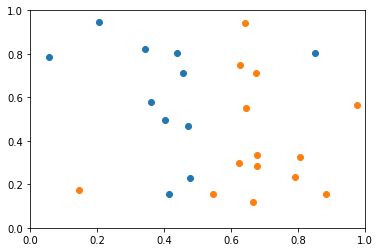

In [14]:
ax.scatter(X[y==-1][:, 0], X[y==-1][:, 1])
ax.scatter(X[y==1][:, 0], X[y==1][:, 1])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig

### Fit

In [15]:
gp.fit(X, y)

In [16]:
gp.kernel_.theta()

[0.20000000000000001, 1.0, 1e-10]

In [17]:
gp.kernel.theta()

[0.2, 1, 1e-10]

### Predict

In [18]:
xx1, xx2 = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
X_test = np.array(list(zip(xx1.ravel(), xx2.ravel())))

In [19]:
gp.predict(X_test)

array([ 1,  1,  1, ..., -1, -1, -1])

In [20]:
probs, mean_f_star, var_f_star = gp.predict_proba(X_test)

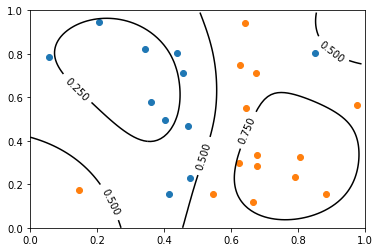

In [21]:
CS = ax.contour(xx1, xx2, probs.reshape(xx1.shape), levels=[0.25, 0.5, 0.75], colors='k')
ax.clabel(CS, inline=1, fontsize=10)
fig

<a list of 9 text.Text objects>

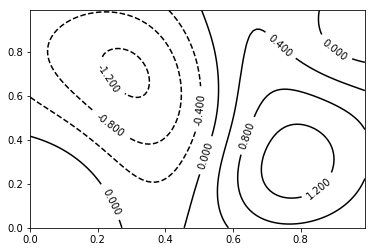

In [22]:
fig, ax = plt.subplots()
CS = ax.contour(xx1, xx2, mean_f_star.reshape(xx1.shape), colors='k')
ax.clabel(CS, inline=1, fontsize=10)

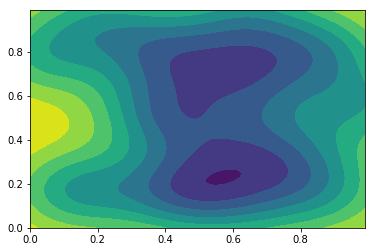

In [23]:
fig, ax = plt.subplots()
CS = ax.contourf(xx1, xx2, var_f_star.reshape(xx1.shape))
#ax.clabel(CS, inline=1, fontsize=10)